#### This notebook was designed to utilized as a short presentation with optional code view. In github, it renders as a static page.

#### Link to dataset utilized: https://www.consumerfinance.gov/data-research/consumer-complaints/

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<button style="Height:50px;font-size:24px" onclick="code_toggle()">View Code</button>''')

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def dateLookup(s):
    """
    Memoization solution for faster date_time parsing
    source: https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [85]:
c = pd.read_csv('../Consumer_Complaints.csv')

#Take subset where complaint text is available
c = c[c['Consumer consent provided?'] == 'Consent provided']

#Convert yes/no strings to bool
for col in ['Consumer disputed?','Timely response?']:
    c[col] = (c[col] == 'Yes')
    
#Convert datetimes    
for col in ['Date received', 'Date sent to company']:
    c[col] = dateLookup(c[col])
    
#All complaints in our subset are submitted via web and have consent provided.
c = c.drop(['Consumer consent provided?','Submitted via'],axis='columns')

#Convert all others, convert yes/no bools to int64
dataTypes = {
    'Product':'category',
    'Sub-product':'category',
    'Issue':'category',
    'Sub-issue':'category',
    'Consumer complaint narrative':str,
    'Company public response':str,
    'Company':'category',
    'State':'category',
    'ZIP code':str,
    'Tags':str,
    'Company response to consumer':'category',
    'Timely response?':'int64',
    'Consumer disputed?':'int64',
    'Complaint ID':'int64'
}

c = c.astype(dataTypes)

columnNames = {
    'Date received':'date_received',
    'Product':'product',
    'Sub-product':'sub_product',
    'Issue':'issue',
    'Sub-issue':'sub_issue',
    'Consumer complaint narrative':'text',
    'Company public response':'pub_reply',
    'Company':'company',
    'State':'state',
    'ZIP code':'zip_code',
    'Tags':'tags',
    'Date sent to company':'date_sent',
    'Company response to consumer':'cust_reply',
    'Timely response?':'timely_reply',
    'Consumer disputed?':'disputed',
    'Complaint ID':'ID'
}

c = c.rename(columns = columnNames)

b = c[c['product'] == 'Bank account or service'].copy()

#There are a few missing state entries, and not every complaint has a sub-product or sub-issue.

#Cleaning Up for Word Vectorization.
#Remove XXXXs
#Are numbers significant/helpful? Is there another format that might make them moreso?
#Strings of XXXX are used for redaction. These will need to be removed.
def remove_redact(text):
    return re.sub('XX/?','',text)

b.loc[:,'clean_text'] = b['text'].apply(remove_redact)

#Make the random sampling consistent when re-run.
np.random.seed(0)

#We'll take a sample of the whole collection and of each issue.
issue_sample_size = 500;
issues = sorted(list(set(b.issue.unique())))

issue_text_samples = {i:b[b['issue'] == i].sample(issue_sample_size)['clean_text'].reset_index(drop=True) for i in issues}
text_globs = pd.Series({i:' '.join(issue_text_samples[i]) for i in issues},index = issues)

print()

# How can we build complaint analytics to help determine what matters to our customers?

## We'd like to have analytics on customer feedback.

Customers are constantly providing feedback that could be of great value in prioritizing which issues to address first. We can overcome the bias in anecdotal summaries of this feedback by seeing how much each issue is actually written about and how each issue has trended over time. Here's an example of what those displays could tell us, based on complaint data about Banking Services from the Consumer Financial Protection Bureau:

### A simple bar chart tells us what people are talking about most

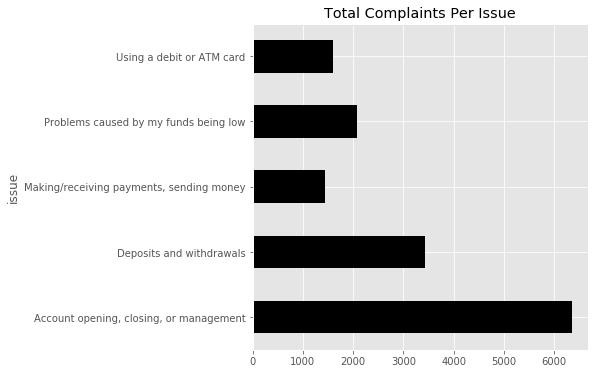

In [86]:
p_issue_class = c.groupby(['product','issue'])['text'].count()
p_issue_class['Bank account or service'].plot(kind='barh',title = 'Total Complaints Per Issue',color='black',figsize=(6,6))
plt.show()
    

### Alternatively, the way these issues have trended tell us if the issue's importance is rising, stable, or declining.

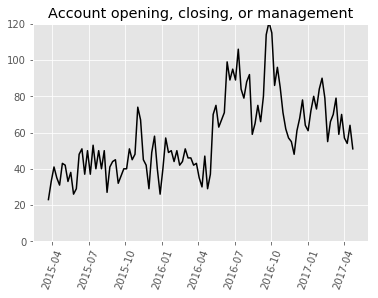

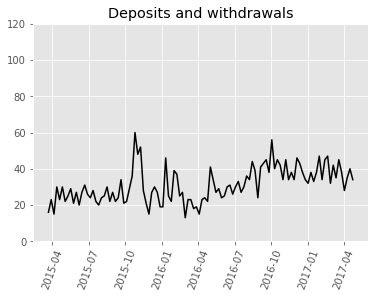

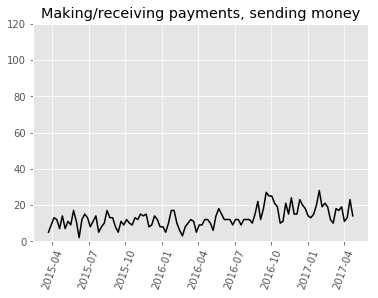

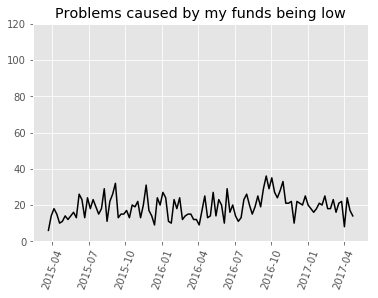

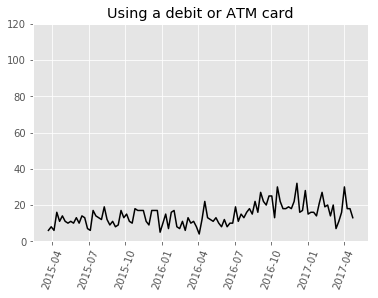

In [5]:
a = b
a.index = b['date_received']
issue_counts = {issue:a[a['issue'] == issue]['issue'].resample('W').count() for issue in issues}
for issue, series in issue_counts.items():
    plt.plot(series,color='black')
    plt.title(issue)
    plt.xticks(rotation=70)
    plt.ylim(0,120)
    plt.show()


### But in order to get this result we'll need data on what issue each ticket addresses. 
#### The tickets could be labelled manually, but this costs human labor. This prompts the question of interest: 

## Can an algorithm label the issue addressed in each message?

Since a human could definitely infer the issue addressed in each message by reading it, we know that the text contains enough information to accurately predict the issue. We just need a good method for quantifying that information so that machine learning models can utilize it. We'll try to reduce the information contained in the language of each ticket to a matrix of features, observations, and labels. The labels will be the issue, the observations will be a message, and the features will be quantifiable aspects of that message. The most prevalent technique for this is a "Bag of Words" matrix that shows how many time each phrase occured in a document.

The phrases we're especially interested are very commonly stated about a specific topic and very rarely stated about other topics. These presence of such phrases should be predictive of the issue, especially when they co-occur. Conversely, we'll have plenty of generic phrases which are common across tickets or appear too rarely to be helpful.

Let's find out what the distribution of specific vs non-specific terms looks like. To do this we'll use a metric formally called TFIDF, designed to measure term specificity. TFIDF balances how often a term occurs in a particular issue against how often it occurs in general. To help us remember what we're talking about, we'll just refer to it as term specificity.

In [6]:
def bow_vectorize(text_series):
    cv = CountVectorizer(stop_words='english',min_df=0.01, ngram_range=(2,30), max_features = 500)
    m = cv.fit_transform(text_series)
    return {'cv':cv,'m':m}

def bow_conform(text_series,feature_names):
    cv = CountVectorizer(stop_words='english',min_df=0.01, ngram_range=(2,30), max_features = 500, vocabulary = feature_names)
    m = cv.fit_transform(text_series)
    return {'cv':cv,'m':m}

def tfidf_vectorize(bow_m):
    tt = TfidfTransformer(norm='l2',smooth_idf=True,use_idf=True)
    m = tt.fit_transform(bow_m)
    return {'tt':tt,'m':m}


### Specific terms in each topic are far outnumbered by generic terms.

### The helpful terms are more plentiful in some topics than in others.

In [7]:
glob_bow = bow_vectorize(text_globs)
glob_tfidf = tfidf_vectorize(glob_bow['m'])

In [8]:
bow_m = glob_bow['m'].todense()
bow_mz = stats.zscore(bow_m,axis=0)
tfidf_m = glob_tfidf['m'].todense()
tfidf_mz = stats.zscore(tfidf_m,axis=0)
feature_names = glob_bow['cv'].get_feature_names()
metrics = ['bow','bow_z','tfidf','tfidf_z']
comp_m = np.concatenate([row for i in range(bow_m.shape[0]) for row in 
                         [bow_m[i,:],bow_mz[i,:],tfidf_m[i,:],tfidf_mz[i,:]]
                        ])
comp_index = pd.MultiIndex.from_product([issues,metrics], names=['Issue', 'Metric'])
feature_index = pd.Index(feature_names,name='Features')
glob_df = pd.DataFrame(comp_m.T,index=feature_index, columns=comp_index)


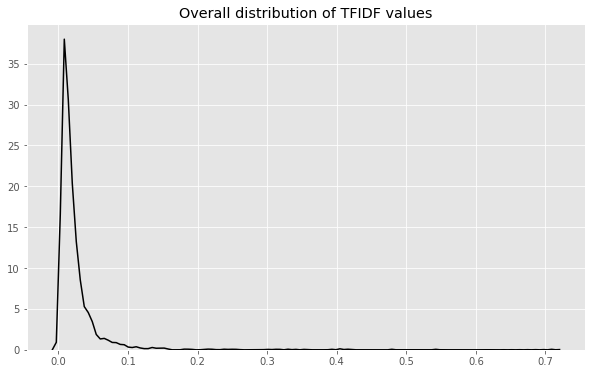

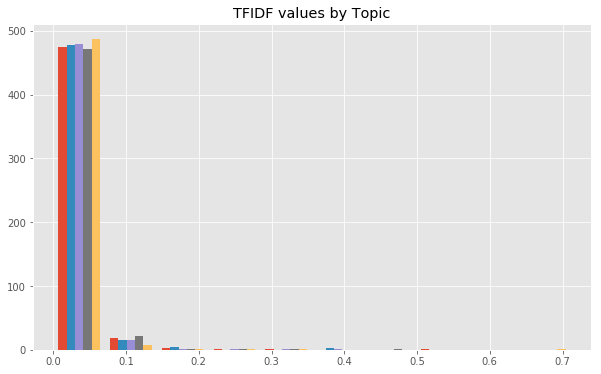

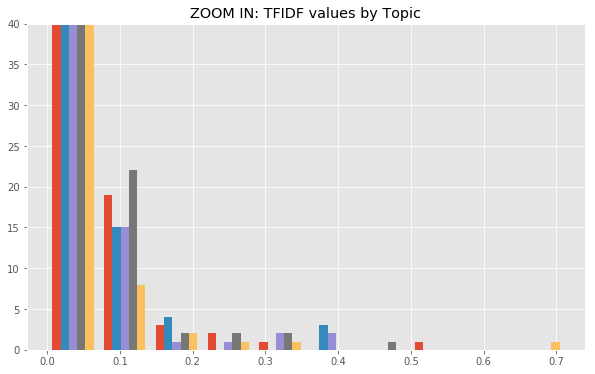

Note that the left-most bars on the x-axis reach well above the cut off on the y-axis here


In [51]:
plt.figure(figsize=(10,6))
plt.title("Overall distribution of TFIDF values")
sns.kdeplot(glob_df.loc[:,(slice(None),'tfidf')].values.flatten(),color="Black")
plt.show()
plt.figure(figsize=(10,6))
plt.title("TFIDF values by Topic")
plt.hist(glob_df.loc[:,(slice(None),'tfidf')].values)
plt.show()
plt.figure(figsize=(10,6))
plt.title("ZOOM IN: TFIDF values by Topic")
plt.ylim(0,40)
plt.hist(glob_df.loc[:,(slice(None),'tfidf')].values)
plt.show()
print("Note that the left-most bars on the x-axis reach well above the cut off on the y-axis here")

### Let's take a look at a few of the most specific terms from each issue.

From a common sense standpoint, these are the terms which appear most often in messages about the given issue but  least often in messages about other issues. Mathematically, each list of phrases is a random sampling of 5 terms from each issue whose tfidf value has a z-score of > 1.9. The z-scores are calculated in terms of the specific topic's distribution of values, as opposed to the total distribution of values.

In [67]:
for issue in issues:
    print('\n',issue+ '\n')
    np.random.seed(47)
    it = glob_df.loc[glob_df.loc[:,(issue,'tfidf_z')] > 1.9].loc[:,(issue,'bow')].sample(5).index
    for i in it:
        print(i)


 Account opening, closing, or management

account opening
terms conditions
close account
opening account
00 balance

 Deposits and withdrawals

account funds
went branch
5000 00
mobile deposit
3000 00

 Making/receiving payments, sending money

discover bank
case number
ally bank
funds returned
number case

 Problems caused by my funds being low

charge overdraft
fee 35 00
account cover
fees bank
bank charged

 Using a debit or ATM card

direct express
new card
used card
card transactions
new debit


### We'll need a good strategy for handling numeric values

The above examples illustrate that numeric values play a peculiar role in our extracted terms. If we transform these into ranges that capture the way they are being uses, these features might retain their specificity whilst becoming more prevalent within the issue as a whole.

### Depending on the problem framing, we may want to remove certain proper nouns.

Names of banks in the CDFI data set that this project utilizes may not be realistic terms to consider, depending on the project's final framing of client + issue.

### How would a classifier do with predicting the topic based on these collections of terms?

A multinomial bayes classifier, based on a straight forward extension of Baye's theorem, was trained to predict the issue based on the term specificity scores for the words in each document.

The heatmap matrix below illustrates the classifier's ability to distinguish between various classes. 

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [69]:
example_set = b.reset_index(drop=True)[['clean_text','issue']]

In [70]:
#assemble training examples and labels for unbalanced set
#Make the vocabulary correspond to the one learned from the topic globs.
examples_bow = bow_conform(example_set['clean_text'],feature_names)
examples_tfidf = tfidf_vectorize(examples_bow['m'])
labels = example_set['issue']

In [72]:
#Take a balanced sampling for an alternative training set and an unbalanced/stratified test set

class_balance = np.array([len(example_set[example_set['issue'] == issue]) for issue in issues])

es_copy = example_set.copy()
training_samples = []
test_samples = []
smallest_class_total = np.min(class_balance)
test_frac = 0.33
training_size = int(np.floor(smallest_class_total*(1-test_frac)))
min_test_size = smallest_class_total-training_size
test_sample_sizes = zip(issues,np.floor(class_balance*(min_test_size/smallest_class_total)))

for issue in issues:
    training_samples.append(es_copy[es_copy['issue'] == issue].sample(training_size,replace=False))
bal_training_set = pd.concat(training_samples)

es_copy = es_copy.drop(bal_training_set.index)
overlap_test=set(es_copy.index).intersection(set(bal_training_set.index))

for issue,test_size in test_sample_sizes:
    test_samples.append(es_copy[es_copy['issue'] == issue].sample(int(test_size),replace=False))
strat_test_set = pd.concat(test_samples)
    

In [73]:
#assemble training examples and labels for balanced set
#Make the vocabulary correspond to the one learned from the topic globs.

bal_training_bow = bow_conform(bal_training_set['clean_text'],feature_names)
bal_training_tfidf = tfidf_vectorize(bal_training_bow['m'])
bal_training_labels = bal_training_set['issue']

strat_test_bow = bow_conform(strat_test_set['clean_text'],feature_names)
strat_test_tfidf = tfidf_vectorize(strat_test_bow['m'])
strat_test_labels = strat_test_set['issue']

bal_X_train,bal_y_train = bal_training_tfidf['m'], bal_training_labels
strat_X_test, strat_y_test = strat_test_tfidf['m'], strat_test_labels

In [77]:
#train a multinomial bayes classifier for both sets
bal_mnb_classifier = MultinomialNB()
bal_mnb_classifier.fit(X=bal_X_train,y=bal_y_train)
print()

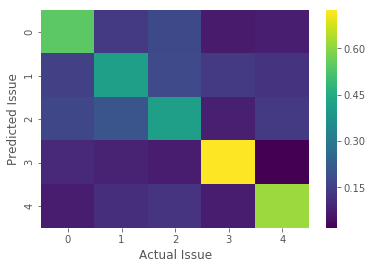

                                          precision    recall  f1-score   support

 Account opening, closing, or management       0.76      0.54      0.63      2095
                Deposits and withdrawals       0.48      0.41      0.45      1130
Making/receiving payments, sending money       0.22      0.41      0.29       472
   Problems caused by my funds being low       0.57      0.72      0.64       688
               Using a debit or ATM card       0.46      0.62      0.53       527

                             avg / total       0.59      0.53      0.55      4912

Num of training examples : [ 960.  960.  960.  960.  960.]

 Some issues are easier to predict than others, and certain pairs seem to blend together.
Hopefully, with some smart feature engineering, the classes will be more seperable.


In [84]:
predictions = bal_mnb_classifier.predict(X=strat_X_test)
confusion = np.matrix(metrics.confusion_matrix(strat_y_test,predictions))
rel_confusion = confusion/confusion.sum(axis=1)
heat = sns.heatmap(rel_confusion,cmap='viridis')
heat.set(xlabel = 'Actual Issue',ylabel = 'Predicted Issue')
plt.show()
print(metrics.classification_report(strat_y_test,predictions))
print('Num of training examples :',bal_mnb_classifier.class_count_)

### Final Thoughts

As you can see above, some issues are easier to predict than others, and certain pairs seem to blend together.

Hopefully, acting on the insight to engineer cleaner features based on numerical values in the text will help to parse the issues apart. There are likely a host of additional ways to meaningfully expand the feature space and an assortment of models that might improve on capturing the true seperability in that feature space.

Additionally, Our model of term specificity presents some interesting issues in practice since we're classifying a single new document rather than a large corpus of documents. In order to gain the advantage of context, we could utilize the Inverse Document Frequency metric from our training data to weight the Term Frequency of the test data. Normally the Term Frequency and Inverse Document Frequency would be computed based on the same corpus.

If we are able to create a sufficiently functional classifier for this and similiar tasks, we will be able to automatically sort incoming messages according to the issue they address. For now, we have a promising start but no definitive success or failure on our classification task.